In [1]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
import yaml
import glob
import plot_helper
from datasets import get_dataset, get_2d_samples
import utils
from nets import load_model
import umap
import tensorflow as tf

import perturbation
import numba


In [2]:
_, test_set, small_set = get_dataset("cifar10", data_path="../datasets")

In [3]:
# oneshot 
# model, summary = load_model("../artifacts-server/mpg-server/experiment-robustness-cifar10-beta03/cifar10-various-opts-M1/resnet20-vdb-diag-cifar10--2019-12-27--05-08-49-724942")

# algo2
model, summary = load_model("../artifacts-server/mpg-server/experiment-robustness-cifar10-beta03/cifar10-various-opts-M1/resnet20-vdb-diag-cifar10--2019-12-27--05-34-08-409372")

Taking nets.resnet20
Using diag covariance
Latent dims: 20
Parameters for latent: 40


In [4]:
batch_size = 100

ds = tf.data.Dataset \
    .from_tensor_slices(test_set)\
    .batch(batch_size)

mu = []
cov = []
labels = []

for i, (x, y) in enumerate(ds):

    _mu, _cov =  model.encode(x)

    mu.append(_mu.numpy())
    
    cov.append(_cov.numpy())
    
    labels.append(y.numpy())

mu = np.concatenate(mu, axis=0)
print("Embedding's shape:", mu.shape)

idx = np.diag_indices(mu.shape[-1])

cov = np.concatenate(cov, axis=0)
print("Cov's shape:", cov.shape)

cov_3d = np.zeros((cov.shape[0], mu.shape[-1], mu.shape[-1]))
cov_3d[:, idx[0], idx[1]] = cov

print("Temp's shape:", cov_3d.shape)


labels = np.array(labels).reshape(-1)
print("Labels's shape:", labels.shape)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Embedding's shape: (10000, 20)
Cov's shape: (10000, 20)
Temp's shape: (10000, 20, 20)
Labels's shape: (10000,)


In [5]:
# np.concatenate([mu])
data_2d = np.concatenate([mu, cov], axis=1)

In [6]:
data_2d[100, :20]

array([-0.18150868, -0.58980846,  0.19637202,  1.1207011 , -0.2944982 ,
       -0.773255  , -1.1565012 ,  1.0190004 ,  1.9551972 ,  0.5174464 ,
        1.20091   ,  0.06006153, -0.23171738, -1.2553608 ,  0.45439252,
        0.81400317,  0.40044254,  0.9750399 , -0.39840153,  1.0206811 ],
      dtype=float32)

In [7]:
mu[100]

array([-0.18150868, -0.58980846,  0.19637202,  1.1207011 , -0.2944982 ,
       -0.773255  , -1.1565012 ,  1.0190004 ,  1.9551972 ,  0.5174464 ,
        1.20091   ,  0.06006153, -0.23171738, -1.2553608 ,  0.45439252,
        0.81400317,  0.40044254,  0.9750399 , -0.39840153,  1.0206811 ],
      dtype=float32)

In [8]:
umean = umap.UMAP().fit_transform(mu);

/Users/heytitle/projects/vib-tensorflow2/venv/lib/python3.7/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../venv/lib/python3.7/site-packages/umap/rp_tree.py", line 135:
@numba.njit(fastmath=True, nogil=True, parallel=True)
def euclidean_random_projection_split(data, indices, rng_state):
^

  state.func_ir.loc))
/Users/heytitle/projects/vib-tensorflow2/venv/lib/python3.7/site-packages/umap/nndescent.py:92: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../venv/lib/python3.7/site-

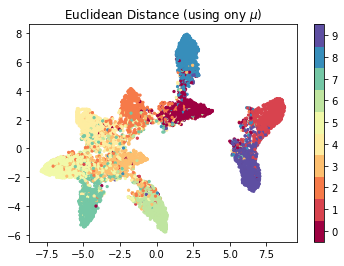

In [9]:
def plot_scatter(embedding, title=""):
    plt.title(title)
    plt.scatter(embedding[:, 0], embedding[:, 1], c=labels, cmap='Spectral', s=5)
    plt.colorbar(boundaries=np.arange(11)-0.5).set_ticks(np.arange(10))
    
plot_scatter(umean, title="Euclidean Distance (using ony $\mu$)")

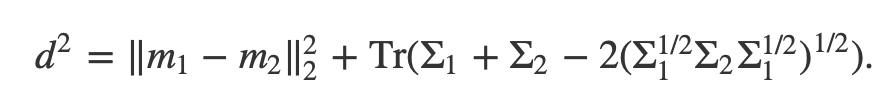

In [10]:
@numba.njit()
def ws_w2(a, b, dim=20):

    mu_a, cov_a = a[:dim], a[dim:]
    mu_b, cov_b = b[:dim], b[dim:]

    cov_a = np.diag(cov_a)
    cov_b = np.diag(cov_b)
    cov_a_sqrt = np.sqrt(cov_a)
    mul_term = np.sqrt(cov_a_sqrt @ cov_b @ cov_a_sqrt)
    
    mu_diff = np.power(np.linalg.norm(mu_a-mu_b), 2)

    return mu_diff + np.trace(cov_a + cov_b - 2*mul_term)


In [11]:
uws_w2 = umap.UMAP(metric=ws_w2).fit_transform(data_2d)

/Users/heytitle/projects/vib-tensorflow2/venv/lib/python3.7/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../venv/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))


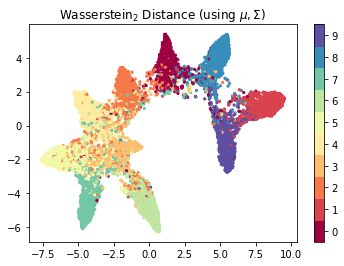

In [12]:
plot_scatter(uws_w2, title="Wasserstein$_2$ Distance (using $\mu, \Sigma$)")

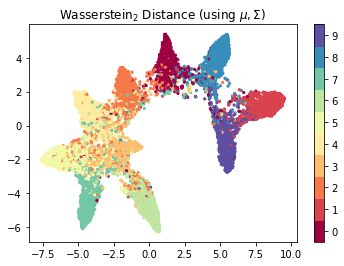

In [13]:
plot_scatter(uws_w2, title="Wasserstein$_2$ Distance (using $\mu, \Sigma$)")